# Build a Tetrahedra with Mixed Domains

In [1]:
from axisvm.com.client import start_AxisVM
axvm = start_AxisVM(visible=True, daemon=True)

In [2]:
import axisvm.com.tlb as axtlb
import numpy as np

modelId = axvm.Models.New()
axm = axvm.Models.Item[modelId]
axm.Settings.NationalDesignCode = axtlb.ndcEuroCode
wdir = ""

Custom Parts

In [3]:
CustomParts = axm.CustomParts
CustomPartsFolder = CustomParts.RootFolder
i = CustomPartsFolder.AddSubFolder('tetra')
Folder = CustomPartsFolder.SubFolder[i]
face_1 = Folder.AddPart('face 1', [])[-1]
face_2 = Folder.AddPart('face 2', [])[-1]
face_3 = Folder.AddPart('face 3', [])[-1]
face_4 = Folder.AddPart('face 4', [])[-1]

Materials

In [4]:
steel = axm.Materials.AddFromCatalog(axtlb.ndcEuroCode, "S 235")
timber = axm.Materials.AddFromCatalog(axtlb.ndcEuroCode, "C24")
xlam = axm.Materials.AddFromCatalog(axtlb.ndcEuroCode, "XLAM")
concrete = axm.Materials.AddFromCatalog(axtlb.ndcEuroCode, "C16/20")

Nodes

In [5]:
# the plate is in the x-y plane
coords = np.zeros((4, 3))  # we have four points in 3d space
coords[0, :] = 0., 0., 0.
coords[1, :] = 1., 0., 0.
coords[2, :] = 0., 1., 0.
coords[3, :] = 0., 0., 1.

fnc = axm.Nodes.Add
nodeIDs = list(map(lambda c: fnc(*c), coords))

Lines

In [6]:
nodes_of_lines = [[0, 1], [1, 2], [2, 0], 
                  [0, 3], [1, 3], [2, 3]]
LineGeomType = axtlb.lgtStraightLine
lineIDs = []
for line in nodes_of_lines:
    lineIDs.append(axm.Lines.Add(nodeIDs[line[0]], nodeIDs[line[1]],
                   LineGeomType, axtlb.RLineGeomData())[1])

Domain

In [7]:
from axisvm.com.tlb import RSurfaceAttr, lnlTensionAndCompression, \
    RResistancesXYZ, schLinear, stShell, RElasticFoundationXYZ, \
    RNonLinearityXYZ, xtldLocalX

steel_surface = RSurfaceAttr(
    Thickness=0.01,
    SurfaceType=stShell,
    RefZId=0,
    RefXId=0,
    MaterialId=steel,
    ElasticFoundation=RElasticFoundationXYZ(0, 0, 0),
    NonLinearity=RNonLinearityXYZ(lnlTensionAndCompression,
                                  lnlTensionAndCompression,
                                  lnlTensionAndCompression),
    Resistance=RResistancesXYZ(0, 0, 0),
    Charactersitics=schLinear)
lines_steel = lineIDs[:3]
domain_steel = axm.Domains.Add(LineIds=lines_steel, SurfaceAttr=steel_surface)[-1]

timber_surface = RSurfaceAttr(
    Thickness=0.01,
    SurfaceType=stShell,
    RefZId=0,
    RefXId=0,
    MaterialId=timber,
    ElasticFoundation=RElasticFoundationXYZ(0, 0, 0),
    NonLinearity=RNonLinearityXYZ(lnlTensionAndCompression,
                                  lnlTensionAndCompression,
                                  lnlTensionAndCompression),
    Resistance=RResistancesXYZ(0, 0, 0),
    Charactersitics=schLinear)
lines_timber = [lineIDs[i] for i in [0, 4, 3]]
domain_timber = axm.Domains.Add(LineIds=lines_timber, SurfaceAttr=timber_surface)[-1]

concrete_surface = RSurfaceAttr(
    Thickness=0.01,
    SurfaceType=stShell,
    RefZId=0,
    RefXId=0,
    MaterialId=concrete,
    ElasticFoundation=RElasticFoundationXYZ(0, 0, 0),
    NonLinearity=RNonLinearityXYZ(lnlTensionAndCompression,
                                  lnlTensionAndCompression,
                                  lnlTensionAndCompression),
    Resistance=RResistancesXYZ(0, 0, 0),
    Charactersitics=schLinear)
lines_concrete = [lineIDs[i] for i in [1, 5, 4]]
domain_concrete = axm.Domains.Add(LineIds=lines_concrete, SurfaceAttr=concrete_surface)[-1]

xlam_surface = RSurfaceAttr(
    Thickness=0.01,
    SurfaceType=stShell,
    RefZId=0,
    RefXId=0,
    MaterialId=xlam,
    ElasticFoundation=RElasticFoundationXYZ(0, 0, 0),
    NonLinearity=RNonLinearityXYZ(lnlTensionAndCompression,
                                  lnlTensionAndCompression,
                                  lnlTensionAndCompression),
    Resistance=RResistancesXYZ(0, 0, 0),
    Charactersitics=schLinear)
lines_xlam = [lineIDs[i] for i in [2, 3, 5]]
domain_xlam = axm.Domains.Add(LineIds=lines_xlam, SurfaceAttr=xlam_surface)[-1]
xlam_panel = axm.XLAMPanels.AddFromCatalog('Binderholz', '3(90)')
axm.Domains.SetXLAMParameters(domain_xlam, xlam_panel, xtldLocalX)

-100023

In [8]:
from axisvm.com.tlb import RPartItem, pitDomain

Folder.AddPartItemsToPart(face_1, [RPartItem(ItemType=pitDomain, Id=domain_steel)])
Folder.AddPartItemsToPart(face_2, [RPartItem(ItemType=pitDomain, Id=domain_timber)])
Folder.AddPartItemsToPart(face_3, [RPartItem(ItemType=pitDomain, Id=domain_concrete)])
Folder.AddPartItemsToPart(face_4, [RPartItem(ItemType=pitDomain, Id=domain_xlam)])

[(<comtypes.gen._0AA46C32_04EF_46E3_B0E4_D2DA28D0AB08_0_16_100.RPartItem at 0x20c1a65a440>,),
 1]

Loads

In [9]:
from axisvm.com.tlb import RPartItem, lgtPermanent, lgtIncidental, gctExclusive

load_group_G = axm.LoadGroups.Add('LG0', lgtPermanent, True, gctExclusive)
load_group_1 = axm.LoadGroups.Add('LG1', lgtIncidental, True, gctExclusive)
load_group_2 = axm.LoadGroups.Add('LG2', lgtIncidental, True, gctExclusive)
load_group_3 = axm.LoadGroups.Add('LG3', lgtIncidental, True, gctExclusive)
load_group_4 = axm.LoadGroups.Add('LG4', lgtIncidental, True, gctExclusive)

In [10]:
from axisvm.com.tlb import lctStandard

load_case_G = axm.LoadCases.AddWithGroup('LCG', lctStandard, load_group_G)
load_case_1 = axm.LoadCases.AddWithGroup('LC1', lctStandard, load_group_1)
load_case_2 = axm.LoadCases.AddWithGroup('LC2', lctStandard, load_group_2)
load_case_3 = axm.LoadCases.AddWithGroup('LC3', lctStandard, load_group_3)
load_case_4 = axm.LoadCases.AddWithGroup('LC4', lctStandard, load_group_4)

In [11]:
from axisvm.com.tlb import RLoadDomainConstant, sddtSurface, sysLocal

LoadDomainConstant = RLoadDomainConstant(
    LoadCaseId=load_case_1, DomainId=domain_steel,
    qx=0, qy=0, qz=-1,
    DistributionType=sddtSurface, SystemGLR=sysLocal
)
axm.Loads.AddDomainConstant(LoadDomainConstant)

LoadDomainConstant = RLoadDomainConstant(
    LoadCaseId=load_case_2, DomainId=domain_timber,
    qx=0, qy=0, qz=-1,
    DistributionType=sddtSurface, SystemGLR=sysLocal
)
axm.Loads.AddDomainConstant(LoadDomainConstant)

LoadDomainConstant = RLoadDomainConstant(
    LoadCaseId=load_case_3, DomainId=domain_concrete,
    qx=0, qy=0, qz=-1,
    DistributionType=sddtSurface, SystemGLR=sysLocal
)
axm.Loads.AddDomainConstant(LoadDomainConstant)

LoadDomainConstant = RLoadDomainConstant(
    LoadCaseId=load_case_4, DomainId=domain_xlam,
    qx=0, qy=0, qz=-1,
    DistributionType=sddtSurface, SystemGLR=sysLocal
)
axm.Loads.AddDomainConstant(LoadDomainConstant)

 4]

In [12]:
from axisvm.com.tlb import ctULS1

caseIDs = [load_case_G, load_case_1, load_case_2, load_case_3, load_case_4]
nC = len(caseIDs)

for i in range(10):
    factors = np.random.rand(nC)
    name = 'Combination {}'.format(i+1)
    axm.LoadCombinations.Add(name, ctULS1, factors, caseIDs)


Supports

In [13]:
spring = axtlb.RStiffnesses(x=1e12, y=1e12, z=1e12, xx=0, yy=0, zz=0)
RNonLinearity = axtlb.RNonLinearity(
    x=axtlb.lnlTensionAndCompression,
    y=axtlb.lnlTensionAndCompression,
    z=axtlb.lnlTensionAndCompression,
    xx=axtlb.lnlTensionAndCompression,
    yy=axtlb.lnlTensionAndCompression,
    zz=axtlb.lnlTensionAndCompression
)
RResistances = axtlb.RResistances(x=0, y=0, z=0, xx=0, yy=0, zz=0)
for id in nodeIDs:
    axm.NodalSupports.AddNodalGlobal(spring, RNonLinearity, RResistances, id)

Meshing

In [14]:
MeshParams = axtlb.RDomainMeshParameters(
    MeshSize=0.1,
    MeshType=axtlb.mtUniform,
    MeshGeometryType=axtlb.mgtTriangle
)
axm.Domains[domain_steel].GenerateMesh(MeshParams)

MeshParams = axtlb.RDomainMeshParameters(
    MeshSize=0.1,
    MeshType=axtlb.mtAdaptive,
    MeshGeometryType=axtlb.mgtTriangle
)
axm.Domains[domain_timber].GenerateMesh(MeshParams)

MeshParams = axtlb.RDomainMeshParameters(
    MeshSize=0.1,
    MeshType=axtlb.mtAdaptive,
    MeshGeometryType=axtlb.mgtMixedQuadTriangle
)
axm.Domains[domain_concrete].GenerateMesh(MeshParams)

MeshParams = axtlb.RDomainMeshParameters(
    MeshSize=0.1,
    MeshType=axtlb.mtAdaptive,
    MeshGeometryType=axtlb.mgtMixedQuadTriangle
)
axm.Domains[domain_xlam].GenerateMesh(MeshParams)


 (),
 (),
 (),
 4]

Calculate

In [15]:
fpath = 'tetrahedra.axs'
axm.SaveToFile(fpath, False)
axm.Calculation.LinearAnalysis(axtlb.cuiNoUserInteractionWithAutoCorrectNoShow)

0

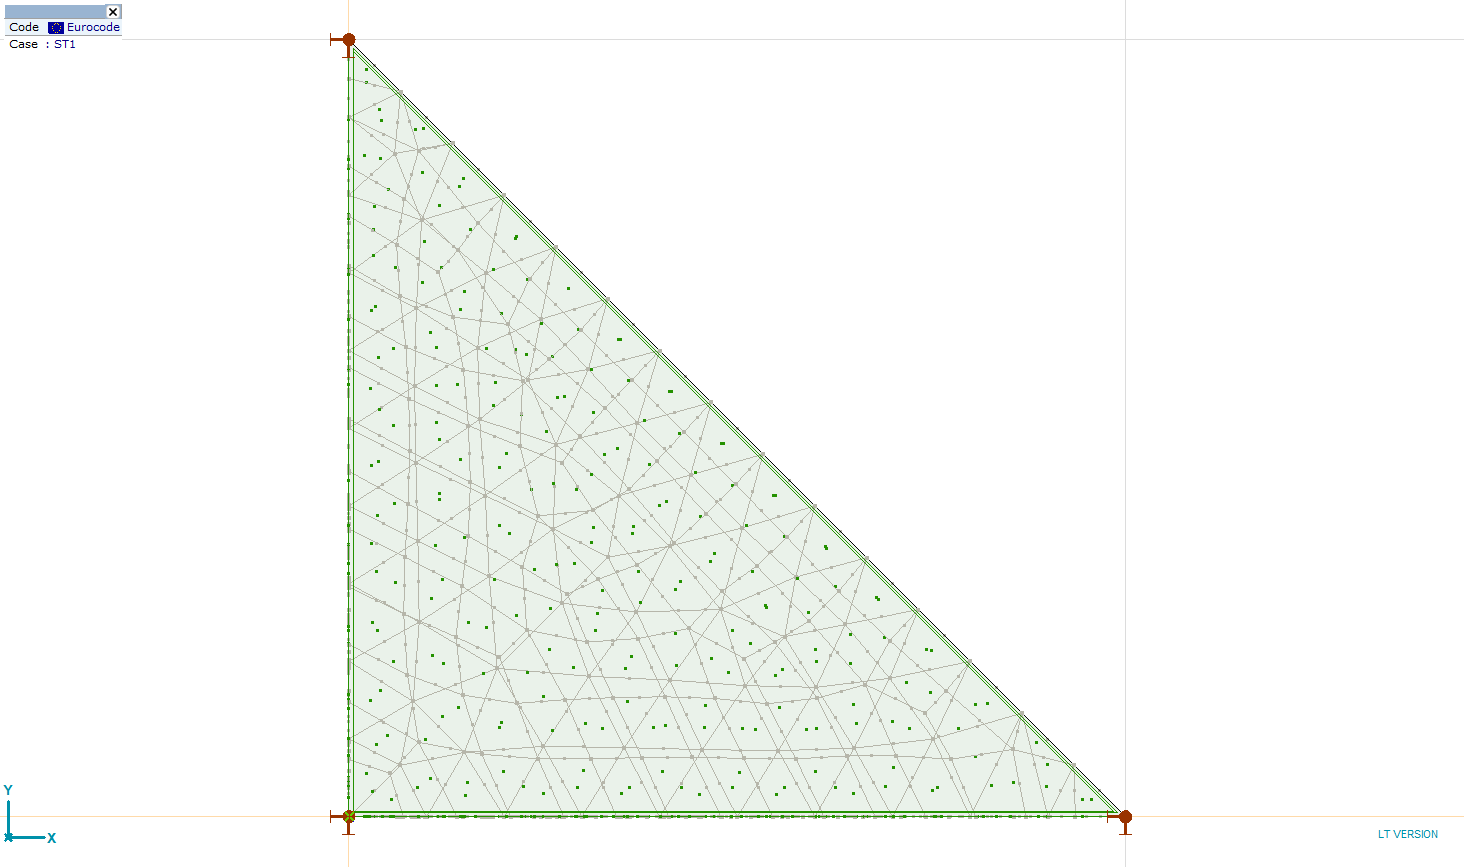

In [16]:
from axisvm.com.tlb import vTop, mftGeometry
axvm.BringToFront()
axm.View = vTop
axvm.MainFormTab = mftGeometry
axm.FitInView()
axm.Windows[1].screenshot()

In [17]:
axvm.Quit()